# Setup/Run PPDisk Simple Model 1 Part 2 - 12CO Lines
* CREDIT: RADMC-3D EXAMPLES
* MODELING TARGET: HD163296

## 00 - About ***radmc3dPy.models.ppdisk module***
Generic protoplanetary disk model<br>
The density is given by

* $\rho = \frac{\Sigma(r,\phi)}{H_p\sqrt{(2\pi)}}\exp{(-\frac{z^2}{2H_p^2})}$

    * $\Sigma$ - Surface density
    * $H_p$ - Pressure scale height

There are two options for the functional form of surface density as a function of radius. For a simple power-law the surface density is given by

* $\Sigma(r)=\Sigma_0 (\frac{r}{r_{out}})^p$

alternatively the surface density can also have an exponential outer tapering:

* $\Sigma(r)=\Sigma_0 (\frac{r}{r_{out}})^p \exp[-(\frac{r}{r_{out}})^{2-p}]$

The molecular abundance function takes into account dissociation and <b>freeze-out of the molecules For photodissociation only the continuum (dust) shielding is taken into account in a way that whenever the continuum optical depth radially drops below a threshold value the molecular abundance is dropped to zero.</b> For freeze-out the molecular abundance below a threshold temperature is decreased by a given fractor.

## 00 - About *HD163296*

### Information:
* Star Class: Herbig Ae/Be star
* Spectral Type: A1Vep C
* Star Mass: 2.3 $M_{\odot}$
* Star Radius: 1.66 $R_{\odot}$
* Star Temperature: 9330 K
* Distance to us: 140. pc
* Inclination Angle: $42^{\circ}$
* Position Angle: $132^{\circ}$
* Disk Radius: 250. unit:AU
* Gap Position: 60., 100., 160. unit:AU
* Gap Width: 33., 26., 55. unit:AU

### Reference:
* *Rosenfeld et al.(2013)*
* *Isella et al. (2016)*
* *Gregorio-Monsalvo et al. (2013)*
* http://simbad.u-strasbg.fr/simbad/sim-id?Ident=HD+163296
* http://www.exoplanetkyoto.org/exohtml/HD_163296.html
* https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html

## 01 - Set Up

In [1]:
#Import NumPy for array handling
#Import plotting libraries (start Python with ipython --matplotlib)

import numpy as np
from radmc3dPy import *
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt

## 02 - Model Parameters

In [2]:
def cal_H(cr):
    '''
    calculate disk scale height
    '''
    H = (16. * (cr/(150.*natconst.au))**1.35) * natconst.au
    return H

### (2) Set Physical Parameters

In [3]:
# Monte Carlo parameters
nphot    = 1000000

# Star parameters
mstar    = 2.3 * natconst.ms
rstar    = 1.66 * natconst.rs
tstar    = 9330.
pstar    = np.array([0.,0.,0.])

# Grid parameters
nr       = 250
ntheta   = 10
nphi     = 1
rin      = 3 * natconst.au
rout     = 253 * natconst.au
thetaup = np.arccos(cal_H(rout)/rout)    # Unit: Radian
print('Open Theta is {:.10f} radian'.format(np.pi/2-thetaup))

# Disk parameters
gammad   = 0.1
gammag   = 0.8

# Ring Gap parameters
Gpc  = [60.*natconst.au, 100.*natconst.au, 160.*natconst.au]         # Unit: cm
#Gwid = [15.*natconst.au, 12.*natconst.au, 15.*natconst.au]           # Unit: cm
#Gcden = [3e-2, 3e-2, 5e-3]                                           # Unit: g/cm^2 (Those are Upper Limits)

# Different Ring Gap parameters
# Widest Gap parameters
Wwid = [33.*natconst.au, 26.*natconst.au, 55.*natconst.au] 
Wdep = [13., 7., 3.6]
# Narrowest Gap parameters
Nwid = [15.*natconst.au, 12.*natconst.au, 15.*natconst.au] 
Ndep = [150., 70., 6.]

Open Theta is 0.1284350655 radian


### (3) Make Parameters

In [4]:
# Make the coordinates
ri       = np.linspace(rin, rout, nr+1)
thetai   = np.linspace(thetaup, 0.5e0*np.pi, ntheta+1)
phii     = np.linspace(0.0e0, np.pi*2.e0, nphi+1)
rc       = 0.5 * (ri[0:nr] + ri[1:nr+1])
thetac   = 0.5 * (thetai[0:ntheta] + thetai[1:ntheta+1])
phic     = 0.5 * (phii[0:nphi] + phii[1:nphi+1])

# Make the grid
qq       = np.meshgrid(rc,thetac,phic,indexing='ij')
rr       = qq[0]
tt       = qq[1]
zr       = np.pi/2.e0 - qq[1]

# Write the wavelength_micron.inp file
lam1     = 0.1e0
lam2     = 7.0e0
lam3     = 25.0e0
lam4     = 1.0e4
n12      = 20
n23      = 100
n34      = 30
lam12    = np.logspace(np.log10(lam1),np.log10(lam2),n12,endpoint=False)
lam23    = np.logspace(np.log10(lam2),np.log10(lam3),n23,endpoint=False)
lam34    = np.logspace(np.log10(lam3),np.log10(lam4),n34,endpoint=True)
lam      = np.concatenate([lam12,lam23,lam34])
nlam     = lam.size

## 04 - Calculate Gas Temperature

### (1) Derived From Known Temperature Dist. 

#### Note: Since assming gas temperature is identical to dust temperature, here I store dust temperature as gas_temperature.inp in order to store both temperature from monte carlo simulation and straight deriviation

In [5]:
def cal_zq(cr):
    '''
    calculate height of disk atmosphere
    '''
    zq0 = 63*natconst.au
    zq = zq0 * (cr/(200*natconst.au))**1.3 * np.exp(-(cr/(800*natconst.au))**2)
    return zq

def cal_delta(cr):
    '''
    calculate vertical shape control parameter
    '''
    delta = 0.0034 * (cr/natconst.au-200) + 2.5
    if delta <= 0.3:
        delta = 0.3
    return delta

def cal_Ta(cr, z):
    '''
    calculate atmosphere temperature
    '''
    #Ta = 55. * (((r**2 + zr**2)**0.5) / (200*natconst.au)) ** (-0.5)
    Ta = 68. * (((cr**2 + z**2)**0.5) / (100*natconst.au)) ** (-0.6)
    return Ta

def cal_Tm(cr):
    '''
    calculate midplane temperature (z=0)
    '''
    #Tm = 19. * (r/(155*natconst.au)) ** (-0.3)
    Tm = 24. * (cr/(100*natconst.au)) ** (-0.5)
    return Tm

def cal_Tgas(cr, z):
    '''
    calculate gas temperature dist.
    '''
    Ta = cal_Ta(cr, z)
    Tm = cal_Tm(cr)
    zq = cal_zq(cr)
    delta = cal_delta(cr)
    if zq > z:
        Tgas = Ta + (Tm - Ta) * np.cos(np.pi/2 * (z/zq)) ** (2*delta)
    else:
        Tgas = Ta
    return Tgas

In [6]:
# Make the gas temperature model
cal_Tgas = np.vectorize(cal_Tgas)
Tgas = cal_Tgas(rr, zr)

# Write the dust density file
with open('gas_temperature.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))     # Nr of cells
    data = Tgas.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

## 06 - Make Input Inp Files

### (1) Gas Temperature

In [7]:
# For now, assuming gas temperature equals to dust temperature

### (2) Molecule Number Density

#### Option - 1 Derived from Gas to Dust Ratio
* CO abundance is from Isella et al. (2016)

In [8]:
# Write the molecule number density file. 
# abunco = 5e-5
# factco = abunco/(2.3*natconst.mp)
# rhogas = 100 * rhod
# nco    = rhogas * factco

#### Option - 2 Derived from CO Density Dist.
* CO abundance is from Isella et al. (2016)
* Gas density dist. is from Rosenfeld et al. (2013)
* The model disk has a gas mass of 0.09$M_{\odot}$, $R_c$ = 115 AU, $\gamma$ = 0.8,  $f_{co}$ = 5 × $10^{−5}$, and $\Sigma_{C}(^{12}$CO) = $1.6 × 10^{−3} gcm^{−2}$.

In [14]:
def cal_H(cr):
    '''
    calculate disk scale height
    '''
    H = (16. * (cr/(150.*natconst.au))**1.35) * natconst.au
    return H

def cal_sigmag_mode2(cr, cden0, rc, gamma):
    '''
    calculate column density
    with taper term
    '''
    cden = cden0 * ((cr/rc)**(-gamma)) * np.exp(-((cr/rc)**(2-gamma)))
    return cden

def cal_gden_mode3(cr, z, cden, gamma):
    '''
    calculate dust density
    from sigmad with taper term
    with known dust column density
    '''
    H = cal_H(cr)
    den = cden / ((2*np.pi)**0.5 * H) * np.exp(-z**2/(2*H**2))
    return den

def make_ring_gap(rc, density, Gpc, wid, dep):
    for i, gp in enumerate(Gpc):
        density[abs(rc-gp) < wid[i]/2] /= dep[i]
    return density

def cal_depletion(n_molecule, T, Tfrz):
    '''
    calculate 12CO depletion factor
    with CO depletion
    '''
    frz =  0.
    if T <= Tfrz:
        n_molecule = frz * n_molecule
    return n_molecule
cal_depletion = np.vectorize(cal_depletion)

In [16]:
sigma12COs = cal_sigmag_mode2(rr*np.cos(zr), 1.6e-3, 165*natconst.au, 0.8)
sigma12CO  = make_ring_gap(rr*np.cos(zr), sigma12COs, Gpc=Gpc, wid=Wwid, dep=Wdep)
gdens12CO  = cal_gden_mode3(rr*np.cos(zr), rr*np.sin(zr), sigma12CO, 0.8)

n12CO = gdens12CO / (28*natconst.mp)
n12CO = cal_depletion(n12CO, Tgas, 19.)

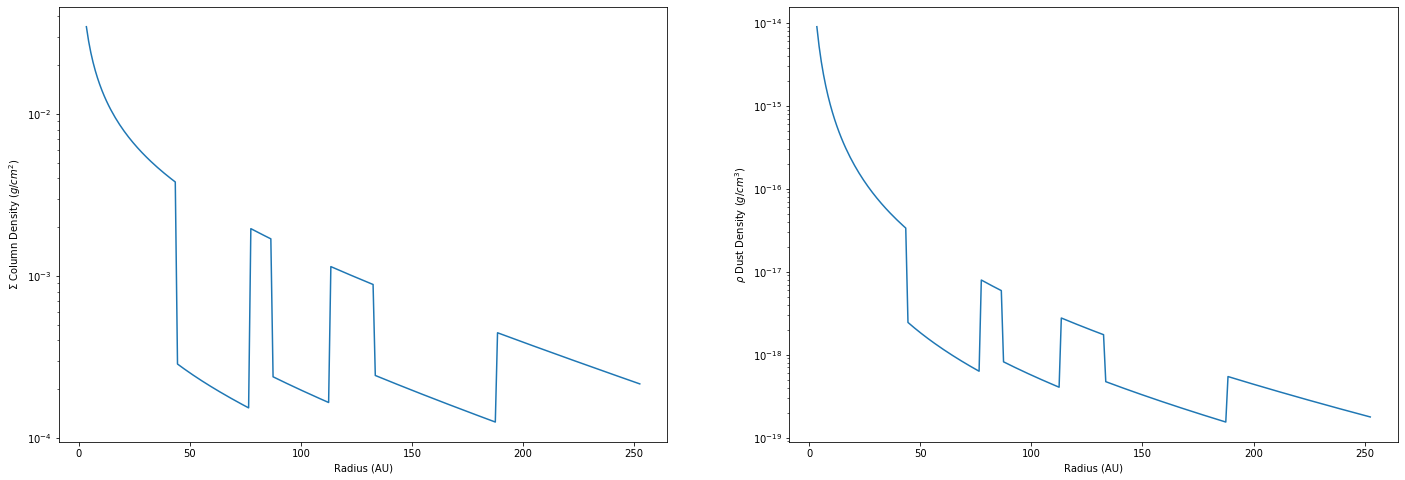

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))
# Plot Column Density (Sigma) wi/wo taper
axes[0].semilogy(rr[:,0,0]/natconst.au, sigma12COs[:,-1,0])
axes[0].set_xlabel(r'Radius (AU)')
axes[0].set_ylabel(r'$\Sigma$ Column Density ($g/cm^2$)')
#axes[0].legend(loc=3)
#axes[0].set_xscale('log')

# Plot Dust Density (Rho) wi/wo taper At z=0
axes[1].semilogy(rr[:,0,0]/natconst.au, gdens12CO[:,-1,0])
axes[1].set_xlabel(r'Radius (AU)')
axes[1].set_ylabel(r'$\rho$ Dust Density ($g/cm^3$)')
#axes[1].legend(loc=3)
#axes[1].set_xscale('log')

plt.show()

In [13]:
with open('numberdens_co.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))           # Nr of cells
    data = n12CO.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

### (3) Gas Velocity

In [38]:
ri       = np.linspace(rin, rout, nr+1, endpoint=True)
thetai   = np.linspace(thetaup, 0.5e0*np.pi, ntheta+1, endpoint=True)
phii     = np.linspace(0.0e0, np.pi*2.0e0, nphi+1, endpoint=True)

vpm = np.zeros((nr, ntheta, nphi))
with open('gas_velocity.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (nr*ntheta*nphi))    # Nr of cells
    for i in range(nphi):
        for j in range(ntheta):
            for k in range(nr):
                r = (ri[k] + ri[k+1]) / 2
                t = np.pi/2 - (thetai[j] + thetai[j]) / 2
                z = r * np.sin(t)
                vpm[k, j, i] = (natconst.gg*mstar)**0.5 * r/((r**2 + z**2)**0.75)
                vr, vt, vp = 0.0, 0.0, (natconst.gg*mstar)**0.5 * r/((r**2 + z**2)**0.75)
                f.write('{:.6e}\t{:.6e}\t{:.6e}\t\n'.format(vr, vt, vp))
np.save('gas_velocity', vpm)

### (4) Gas Velocity Turbulence

In [39]:
vturb0  = 0.0 #3.0e5
vturb   = np.zeros((nr,ntheta,nphi)) + vturb0

# Write the microturbulence file
with open('microturbulence.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(nr*ntheta*nphi))           # Nr of cells
    data = vturb.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

### (5) Molecule Line Information

In [40]:
# Write the lines.inp control file
with open('lines.inp','w+') as f:
    f.write('1\n')
    f.write('1\n')
    f.write('co    leiden    0    0\n')

### (6) Line Radmc3d Input (Control File for Molecule Lines)

In [41]:
# Add Line parameter to Dust radmc3d.inp control file
with open('radmc3d.inp','w+') as f:
    f.write('nphot = %d\n' % (nphot))
    f.write('scattering_mode_max = 0\n')   # Put this to 1 for isotropic scattering
    f.write('modified_random_walk = 1\n')  # Put this to 1 for random walk
    f.write('tgas_eq_tdust   = 0')